## Part 3 - Employ notebooks to synthesize query project results

### What are the 5 most popular trips that you would call "commuter trips"? 
My definition of "commuter trips" are trips that meet the following criteria:
- On Monday-Friday
- Between the hours of  5-10 AM (morning commute) or 3-8 PM (afternoon commute)
- Are made by 'subscriber' customers 
- That start and end at different stations 

In [273]:
#!pip install plotly
import pandas as pd

In [274]:
%%bigquery _1_AllTripsCount 

SELECT Count(1) AS Count
FROM 
  `bigquery-public-data.san_francisco.bikeshare_trips`

In [275]:
%%bigquery _2_WeekdayCritera

WITH TripTable AS (
SELECT start_date, start_station_name, end_station_name, subscriber_type, EXTRACT(HOUR FROM start_date) AS TripHour,
  EXTRACT(DAYOFWEEK FROM start_date) AS TripDayOfWeek
FROM 
  `bigquery-public-data.san_francisco.bikeshare_trips`
)
SELECT COUNT(1) AS Count FROM TripTable 
WHERE TripDayOfWeek IN (2,3,4,5,6)

In [276]:
%%bigquery _3_TimeCritera

WITH TripTable AS (
SELECT start_date, start_station_name, end_station_name, subscriber_type, EXTRACT(HOUR FROM start_date) AS TripHour,
  EXTRACT(DAYOFWEEK FROM start_date) AS TripDayOfWeek
FROM 
  `bigquery-public-data.san_francisco.bikeshare_trips`
)
SELECT COUNT(1) AS Count FROM TripTable 
WHERE TripDayOfWeek IN (2,3,4,5,6)
    AND TripHour IN (5,6,6,7,8,9,10,15,16,17,18,19,20)


In [277]:
%%bigquery _4_Subscribers

WITH TripTable AS (
SELECT start_date, start_station_name, end_station_name, subscriber_type, EXTRACT(HOUR FROM start_date) AS TripHour,
  EXTRACT(DAYOFWEEK FROM start_date) AS TripDayOfWeek
FROM 
  `bigquery-public-data.san_francisco.bikeshare_trips`
)
SELECT COUNT(1) AS Count FROM TripTable 
WHERE TripDayOfWeek IN (2,3,4,5,6)
    AND TripHour IN (5,6,6,7,8,9,10,15,16,17,18,19,20)
    AND subscriber_type = "Subscriber"


In [278]:
%%bigquery _5_DifferentStations

WITH TripTable AS (
SELECT start_date, start_station_name, end_station_name, subscriber_type, EXTRACT(HOUR FROM start_date) AS TripHour,
  EXTRACT(DAYOFWEEK FROM start_date) AS TripDayOfWeek
FROM 
  `bigquery-public-data.san_francisco.bikeshare_trips`
)
SELECT COUNT(1) AS Count FROM TripTable 
WHERE TripDayOfWeek IN (2,3,4,5,6)
    AND TripHour IN (5,6,6,7,8,9,10,15,16,17,18,19,20)
    AND subscriber_type = "Subscriber"
    AND start_station_name <> end_station_name


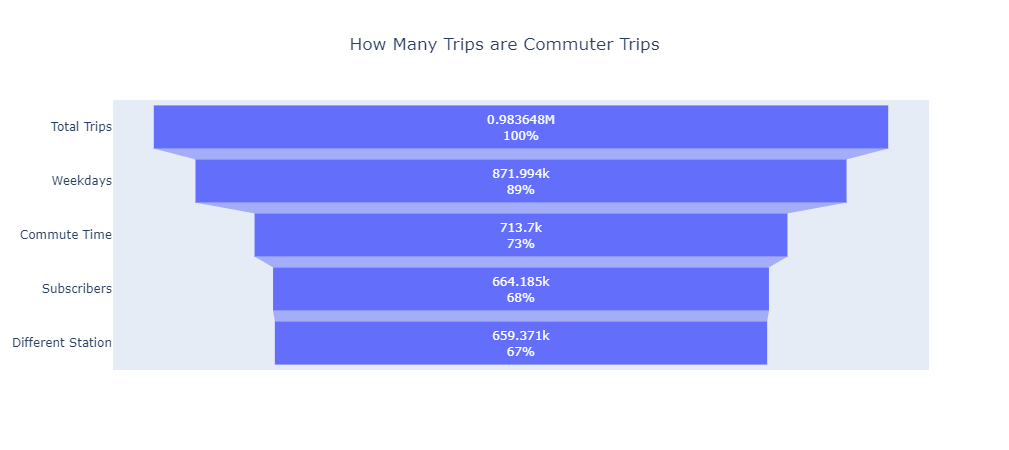

In [279]:
from plotly import graph_objects as go

fig = go.Figure(go.Funnel(
    y = ["Total Trips", "Weekdays", "Commute Time", "Subscribers", "Different Station"],
    x = [
        int(_1_AllTripsCount.Count), 
            int(_2_WeekdayCritera.Count),
            int(_3_TimeCritera.Count),
            int(_4_Subscribers.Count), 
            int(_5_DifferentStations.Count)
    ],
    textposition = "inside",
    textinfo = "value+percent initial")
    )

fig.update_layout(
    title={
        'text': "How Many Trips are Commuter Trips",
        'x':0.5} ,
)


fig.show()


In [280]:
%%bigquery _5_DifferentStations

WITH TripTable AS (
SELECT start_date, start_station_name, end_station_name, subscriber_type, EXTRACT(HOUR FROM start_date) AS TripHour,
  EXTRACT(DAYOFWEEK FROM start_date) AS TripDayOfWeek, duration_sec
FROM 
  `bigquery-public-data.san_francisco.bikeshare_trips`
)
SELECT COUNT(1) AS Count, start_station_name, end_station_name, AVG(duration_sec/60) AS avg_minutes FROM TripTable 
WHERE TripDayOfWeek IN (2,3,4,5,6)
    AND TripHour IN (5,6,6,7,8,9,10)
    AND subscriber_type = "Subscriber"
    AND start_station_name <> end_station_name
GROUP BY start_station_name, end_station_name
ORDER BY Count DESC
LIMIT 5

These are the top 5 commuter trips. Note, I am only showing the morning leg of the commute. This way you will see 5 different station pairs.  The afternoon leg of the commute for the top commutes is the same, but the stations are reversed. 

In [281]:
_5_DifferentStations

,Count,start_station_name,end_station_name,avg_minutes
0,4850,Harry Bridges Plaza (Ferry Building),2nd at Townsend,9.470897
1,4296,San Francisco Caltrain (Townsend at 4th),Temporary Transbay Terminal (Howard at Beale),11.469503
2,4143,San Francisco Caltrain 2 (330 Townsend),Townsend at 7th,4.922194
3,4077,Steuart at Market,2nd at Townsend,8.556271
4,3684,San Francisco Caltrain (Townsend at 4th),Embarcadero at Folsom,10.435166


### Geographic Exploration 
The following section is an exloration of using geopandas to create a map using geopandas. 

I started with the sample provided by the instructor and plotted the locations of all of the stations. 

In [284]:
#Required packages
#!pip install geopandas
#!pip install shapely
#!pip install descartes
#!pip install contextily

In [285]:
%%bigquery stations

SELECT station_id, latitude, longitude, COUNT(1) AS Total_trips FROM `bigquery-public-data.san_francisco.bikeshare_stations` bikeshare_stations
JOIN `bigquery-public-data.san_francisco.bikeshare_trips` bikeshare_trips
ON bikeshare_stations.station_id = bikeshare_trips.start_station_id
GROUP BY station_id, latitude, longitude

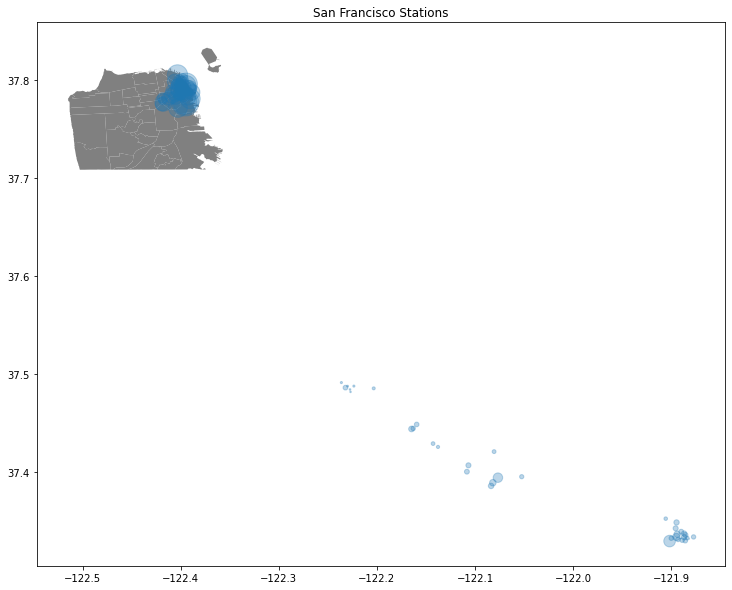

In [286]:
import pandas as pd
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import matplotlib.pyplot as plt
import geopandas as gpd
from shapely import geometry
import contextily as ctx

Point = geometry.Point

#assign the results of the query to the object called coord_start
coord_start = stations 

# Read the neighborhoods
sf = gpd.read_file("geojson/Analysis Neighborhoods.geojson")
sf = sf.rename(columns={'geometry': 'geometry','nhood':'neighborhood_name'}).set_geometry('geometry')
# Set up the data for plotting
coord_start['geometry'] = coord_start.apply(lambda row: Point(row['longitude'], row['latitude']), axis=1)
crs = {'init': 'epsg:4326'}
data = gpd.GeoDataFrame(coord_start, crs=crs, geometry = 'geometry')
# Plot the 2 things together
fig, ax = plt.subplots(1, figsize=(13,10))
sf_map = sf.plot(ax=ax, color='gray')
data.plot(ax=sf_map, marker="o", markersize=data['Total_trips']/100, alpha=0.3)
ax.set_title("San Francisco Stations")
plt.show()

There are problems with this visualization because there are several stations south of San Francisco that are not included in the neighborhoods json file. To map all of the stations I will use the contextily package to add a background that shows the area as well as the names names of the different regions of the Bay Area. 

Text(0.5, 1.0, 'Bay Area Stations')

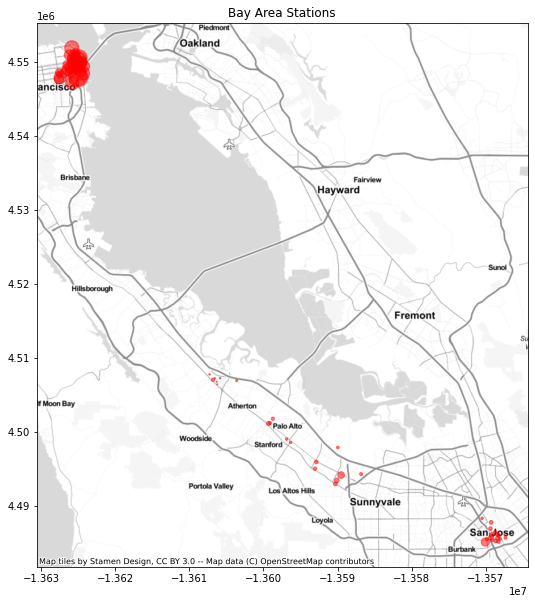

In [287]:
ax = data_crs.plot(figsize=(13,10),column='Total_trips', markersize=data['Total_trips']/200, color='red', alpha=0.5)  
ctx.add_basemap(ax, url=ctx.providers.Stamen.TonerLite)
ax.set_title("Bay Area Stations")

With this map I can see that most of the trips are in the northeast corner of San Francisco. The Silicon Valley stations (Palo Alto, Sunnyvale, and San Jose) are used much less. Though, the stations in San Jose are used more than the other Silicon Valley stations. 

## Recommendations for offers
After analyzing this ride data there are 2 main issues that I would recomend that they address.
- Ridership is very low outside of the weekday commuter hours.
- Usage is low in the cities other than San Francisco.

To improve ridership on weekends I would consider the following offers:
- Weekend only pass (for non-subscribers). A low-prices subscription that is only works for rides on the weekend. 
- Friends and family pass. On weekends, subscribers can also rent a 2nd bike for a friend or family use to go on a trip together. 

To improve ridership in silicon valley:
- Silicon valley only pass at a cheaper rate that does not work for trips in San Francisco. 
- 1 month free introductory offer to encourage more people in Silicon Valley to try the pass. 
- Corporate passes. There are many companies in Silicon Valley that provide many nice benifits to their employees. They should do business deals with HR departments of Silicon Valley companies who can offer bike passes as a benefit to their employees. They can also build stations on the campuses of some of these companies. 